### CS 575 Final Project

Description and solution to the final project in CS 575 for fall semester 2025.

- Mike Goodrich
- Brigham Young University
- March 2025

---

### Prior Project

The previous project constructed the person-person network by
- constructing a knowledge graph with the following 
  - node types
    - person
    - thread
    - channel
  - edge types
    - posted in thread
    - posted in channel
    - replied to
- using one-mode projection to form the person-person network

The project then had students apply node metrics and graph partitioning metrics to find 
- influential nodes
- community structures and inter-community bridges

Given the influential nodes and community structures, students then had to 
- develop a strategy for choosing early adopters so that a complex contagion could spread on the network
- simulate the complex contagion on the network to see how well their design worked

---


### Proposed Project

The proposed project shifts from social structure to semantic structure. A different graph schema will be used so that students can build a network that connects related messages. The proposed learning objectives are

**Learning Objectives**
- Design a knowledge graph schema based on textual content.
- Apply embedding techniques to short, informal text.
- Use GNNs to embed nodes based on content and relationships.
- Interpret clusters of embedded text data.

I've worked with ChatGPT-4o to create the following specification. The rest of this notebook will elaborate and implement the specification.

1. **Build the Knowledge Graph**
  - Nodes: Messages (from edges.csv — each message is a unique edge with content).
  - Edges between messages (Students will use edges.csv and nodes.csv to map messages to threads/channels/authors.):
    - Same author
    - Same recipient
    - Same channel
    - Same thread
    - Optional: same author and receiver
    - Optional: time adjacency (within X minutes in same thread)


2. **Form "Related Message" Network**
  - Find biadjacency matrix with messages as columns
  - Use one-mode projection to form adjacency matrix for which messages are related to which other messages

3. **Extract Feature Vectors for Messages**
  - Use one of the feature extraction strategies above. These are precanned methods for extracting features that won't be taught in class.
  - The feature vector for each message node is initialized with its vector.

4. **Train a GNN to Learn Embeddings**
  - Use a simple GCN or GAT with 2–3 layers.
  - Train using unsupervised objectives (e.g., Deep Graph Infomax or contrastive loss). I propose to use _reconstruction loss_ since I'll have taught that
  - Alternatively, treat it as node classification if you can weakly label messages by topics (optional).

5. **Visualize and Cluster**
  - Project the learned node embeddings using t-SNE or UMAP.
  - Cluster using KMeans or DBSCAN.
  - Display representative messages from each cluster.

6. **Analyze**
  - What kinds of messages cluster together?
  - Do clusters correlate with authors, channels, threads?
  - How do different edge definitions affect the graph (e.g., adding reply edges vs. not)?

The remainder of this notebook will go through these steps.

---

### Build the Knowledge Graph

#### Step 1: Extract Nodes

Read the `nodes.csv` file into a pandas dataframe and inspect the header. 


In [112]:
import pandas as pd
nodes_data = pd.read_csv('cs236_data/nodes.csv')
nodes_data.head()

,node,type,value
0,530,person,TA
1,0,person,TA
2,80,person,Student
3,531,person,Student
4,162,person,Student


- The entries in the node column are unique _node IDs_
- The entries in the node column are _node types_
  - person
  - thread
  - channel
- The entries in the value column depend on the node type
  - person values are one of
    - TA
    - Student
    - Instrutor
  - channel values are one of the channels in the Discord server
    - general
    - project 1
    - etc
  - thread values are the names given to the thread which are one of the following
    - names chosen by the person initiating the thread
    - first few words from the message from which the thread spawned

We can illustrate this relationship.

<img src="figures/nodes_organization.png" alt="Hierarchical relationship among nodes in nodes.csv" width = "800">

Start building the knowledge graph by extracting three node types: person, channel, thread.  Each vertex in the graph will have three properties:
- unique vertex ID (which will not be the same as the node ID)
- vertex type
  - person
  - channel
  - thread
- vertex value
  - type of person
  - channel name
  - thread name

Read edge data and get familiar with it

In [113]:
import networkx as nx
from typing import Tuple

def add_nodes_from_node_dataframe(dataframe: pd.DataFrame,
                                  G: nx.Graph
                                  ) -> Tuple[nx.Graph, dict[int, int]]:
    """ 
        Take an empty graph and populate it with nodes.
        Inputs
          • dataframe is a pandas dataframe for node types
          • G is a graph with no edges and no nodes
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • A dictionary that allows the vertex ID in the graph to be looked up
            from node ID in the file
        Note attributes
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) > 0:
        raise ValueError("Graph must be empty")
    
    nodeID_to_vertexID: dict[int, int] = dict()

    # For each row in the nodes.csv dataframe
    for vertex_ID, row in dataframe.iterrows():
        G.add_node(vertex_ID,
                   node_ID = int(row['node']), 
                   node_type = str(row['type']),
                   node_value = str(row['value']))
        nodeID_to_vertexID[row['node']] = vertex_ID
    return G, nodeID_to_vertexID


Confirm that we are getting the node that we want. 

In [114]:
G = nx.Graph()
G, nodeID_to_vertexID = add_nodes_from_node_dataframe(nodes_data, G)
for node, attrs in G.nodes(data=True):
    print(f"node {node} has attributes: ID = {attrs.get('node_ID')}, type = {attrs.get('node_type')}, value = {attrs.get('node_value')[:2]}")
    if node > 10: 
        break

node 0 has attributes: ID = 530, type = person, value = TA
node 1 has attributes: ID = 0, type = person, value = TA
node 2 has attributes: ID = 80, type = person, value = St
node 3 has attributes: ID = 531, type = person, value = St
node 4 has attributes: ID = 162, type = person, value = St
node 5 has attributes: ID = 7, type = person, value = St
node 6 has attributes: ID = 532, type = person, value = St
node 7 has attributes: ID = 533, type = person, value = St
node 8 has attributes: ID = 534, type = person, value = St
node 9 has attributes: ID = 535, type = person, value = St
node 10 has attributes: ID = 536, type = person, value = St
node 11 has attributes: ID = 537, type = person, value = St


Look at graph to make sure things make sense

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import Hashable

def show_graph(G: nx.Graph, 
               categories: list[str],
               pos: dict[Hashable, Tuple[float,float]] | None = None,
               title: str = "Graph from pandas dataframe"
               ) -> None:
    color_template: dict[str, str] = {'person': 'lightblue', 
                                    'thread': 'y', 
                                    'channel': 'salmon', 
                                    'message': 'm'}
    # Need to add error checking. That is where the categories argument will be used
    node_colors: list[str] = []
    for node in G.nodes():
        if G.nodes[node]['node_type'] == 'name':
            node_colors.append(color_template['name'])
        elif len(G.nodes[node]['node_type'].split(",")) > 1:
            node_colors.append(color_template['combo'])
        else:
            node_colors.append(color_template[G.nodes[node]['node_type']])

    plt.figure()
    #pos = nx.spring_layout(G)
    #pos = nx.nx_pydot.pydot_layout(G, prog="neato")
    if pos is None:
        try:
            pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
        except Exception as e:
            print(f"Graphviz layout failed, falling back to spring_layout: {e}")
            pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha=0.5,node_size=20 )
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.5)
    
    # create and add legend
    legend_patches = [mpatches.Patch(color=color, label=category) for category, 
                    color in color_template.items() if category in categories]
    _ = plt.legend(handles=legend_patches, title="Node Types", loc="best")

    # Add the title
    _ = plt.title(title)
    _ = plt.axis('off')

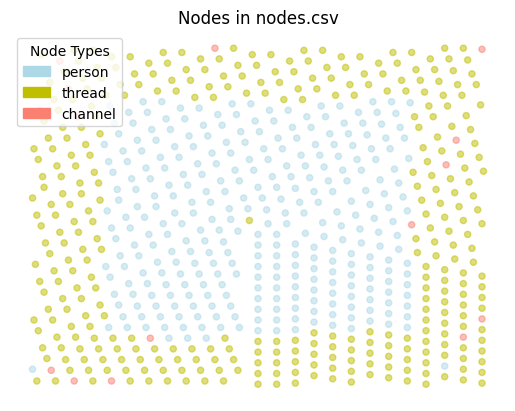

In [116]:
show_graph(G, ["person", "thread", "channel"], title = "Nodes in nodes.csv")

#### Step 2: Add Edges

Add a node for each message in `edges.csv`. The columns are
- _source_: the source of the message
- _target_: the destination of the message
- _edge type_: determined by the destimation of the message
  - `posted_in_channel` means the source is a person and the target is a channel
  - `replied_to` means the source is a person and the target is a person
  - `posted_in_thread` mens the source is a person and the target is a channel
  - `thread_in_channel` means the source is a thread and the thread is in a channel
- _content_: determined by the edge type
  - the message if the edge type is anything but `thread_in_channel`
  - empty if the edge type is `thread_in_channel`

We can illustrate this relationship.

<img src="figures/edges_organization.png" alt="Hierarchical relationship among edges in edges.csv" width = "600">

Let's confirm this pattern

In [117]:
edges_data = pd.read_csv('cs236_data/edges.csv')
edges_data.head()

,source,target,edge_type,content
0,0,1,posted_in_channel,Project Submission Question
1,0,0,replied_to,I'm feeling better so I'll be in at around 11:30
2,0,2,replied_to,Nope
3,0,3,replied_to,Will there be any TAs today?
4,0,4,replied_to,"Yes, see the <#1148663286267641906> for specif..."


#### Step 3: Define Graph Schema

We must have a new graph schema when we include messages as graph vertices. 

<img src="figures/project_3_graph_schema.png" alt="Graph schema for project 3" width = "400">

The function that adds edges must implement this schema.

#### Step 4: Add Edges According to the Schema

In [118]:
def add_edges(G: nx.Graph,
              dataframe: pd.DataFrame,
              nodeID_to_vertexID: dict[int,int]
              ) -> nx.Graph:
    """ 
        Take a graph populated with nodes and add an edge according to the Graph Schema
        Inputs
          • G is a graph with no edges but with nodes having the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • dataframe is a pandas dataframe for node types
          • nodeID_to_vertexID: a dictionary that allows easy mapping from the node ID used 
            in the database to the vertex ID used in the graph
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
        Note attributes
          • The node ID is an int
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) == 0:
        raise ValueError("Graph must be populated with nodes before adding messages")
    
    # For each row in the nodes.csv dataframe
    for _, row in dataframe.iterrows():
        source_vertex: int = nodeID_to_vertexID[row['source']]
        target_vertex: int = nodeID_to_vertexID[row['target']]
        G.add_edge(source_vertex, target_vertex, edge_type = row['edge_type'])
    return G

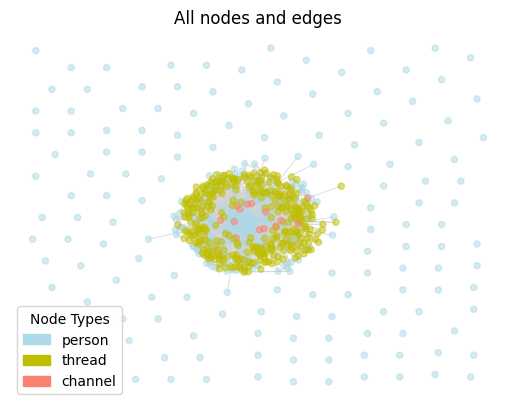

In [119]:
G = add_edges(G, edges_data, nodeID_to_vertexID)
# Try to get position from graphviz
try:
    pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
except Exception as e:
    print(f"Graphviz layout failed, falling back to spring_layout: {e}")
    pos = nx.spring_layout(G, seed=42)
show_graph(G, 
           ["person", "thread", "channel"], 
           pos = pos,
           title = "All nodes and edges")

save graph to a file that students can use

In [140]:
import pickle
with open("project_3_graph.pkl", "wb") as f:
    pickle.dump(G, f)
nx.write_graphml(G, "project_3_graph.graphml")

Does each node have positive degree?

In [120]:
for node in G.nodes():
    if G.degree(node) == 0:
        print(f"vertex {node} has degree 0 and its node id is {G.nodes[node]['node_ID']}")
        print(f"its type is {G.nodes[node]['node_type']} and its value is {G.nodes[node]['node_value']}")

vertex 0 has degree 0 and its node id is 530
its type is person and its value is TA
vertex 3 has degree 0 and its node id is 531
its type is person and its value is Student
vertex 6 has degree 0 and its node id is 532
its type is person and its value is Student
vertex 7 has degree 0 and its node id is 533
its type is person and its value is Student
vertex 8 has degree 0 and its node id is 534
its type is person and its value is Student
vertex 9 has degree 0 and its node id is 535
its type is person and its value is Student
vertex 10 has degree 0 and its node id is 536
its type is person and its value is Student
vertex 11 has degree 0 and its node id is 537
its type is person and its value is Student
vertex 12 has degree 0 and its node id is 538
its type is person and its value is Student
vertex 13 has degree 0 and its node id is 539
its type is person and its value is Student
vertex 18 has degree 0 and its node id is 540
its type is person and its value is Student
vertex 20 has degree 

What does this mean? It means that there are about 140 people who had accounts in the class that never posted anything, including one TA

Peak at the largest component

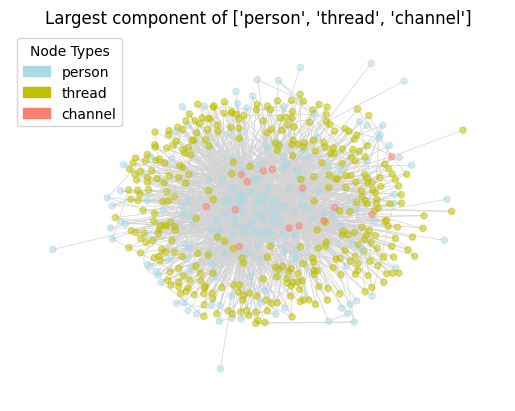

In [121]:
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph with only the largest component
largest_subgraph = G.subgraph(largest_cc).copy()
show_graph(largest_subgraph, 
           ["person", "thread", "channel"],
           pos = pos,
           title = f"Largest component of {[node_type for node_type in ["person", "thread", "channel"]]}")

What are some graph metrics?

In [122]:
print(f"density = {nx.density(largest_subgraph)}")
print(f"assortativity = {nx.degree_assortativity_coefficient(largest_subgraph)}")
print(f"transitivity = {nx.transitivity(largest_subgraph)}")

density = 0.01326104790098798
assortativity = -0.4252865628392353
transitivity = 0.07752702446425185


---

### Form "Related Persons" Network

#### Step 1: Find Biadjacency Matrix

In [123]:
import numpy as np
from numpy.typing import NDArray
def get_biadjacency_matrix(G: nx.Graph,
                           row_types: list[str],
                           column_types: list[str]
                           ) -> NDArray[np.float32]:
    # Error handling
    if len(row_types) == 0 or len(column_types) == 0:
        raise ValueError("Must specify node types for both row and column nodes")
    
    # Get list of nodes from each node partition
    list_0: list[Hashable] = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in row_types] 
    if len(list_0) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the row set {row_types}")
    list_1: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in column_types]) 
    if len(list_1) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the column set {column_types}")


    biadjacency_matrix:NDArray = nx.bipartite.biadjacency_matrix(G, 
                                                                 row_order=list_0, 
                                                                 column_order=list_1).toarray()
    return biadjacency_matrix

In [137]:
B = get_biadjacency_matrix(G, ['thread', 'channel'], ['person'])
#B = get_biadjacency_matrix(G, ['thread'], ['person'])

print(B)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Step 2: Create Adjacency Matrix

Use one-mode projection.

In [125]:
A = B.T@B
np.fill_diagonal(A, 0)
A[A > 1] = 1

#### Step 3: Create Graph 

The adjacency matrix can be used to create a new graph, but the graph will have lost the information about what is in the person nodes. Once we create the graph using the adjacency matrix, add the person information to the nodes in the new graph.

In [126]:
G_mm: nx.Graph = nx.from_numpy_array(A)

# Because I sorted the nodes in the "message" partition when I created the 
# biadjacency matrix, I can find a one-to-one mapping from the nodes in the
# new graph and the nodes in the old.

# Get sorted list of message nodes.
person_nodes: list[Hashable] = sorted([node for node in G.nodes() if G.nodes[node]['node_type'] == 'person'])

print(f"There are {len(G_mm)} nodes in the new graph.")
print(f"There are {len(person_nodes)} person nodes in the old graph.")

for node_index in range(len(G_mm)):
    G_mm.nodes[node_index]['node_type'] = 'person'
    person_vertex: int = person_nodes[node_index]
    G_mm.nodes[node_index]['node_value'] = G.nodes[person_vertex]['node_value']
    if G.nodes[person_vertex]['node_type'] != 'person':
        print(f"node {node_index} in new graph is node {person_vertex} in old")
        print(f"in the old graph, vertex {person_vertex} has type {G.nodes[person_vertex]['node_type']} and value {G.nodes[person_vertex]['node_value']}")
        raise ValueError("Trying to add a non-person to the person-person graph")
for i in range(len(G_mm)):
    if i%25==0:
        print(f"Person {i} is a {G_mm.nodes[i]['node_type']} who is a {G_mm.nodes[i]['node_value']}")

There are 315 nodes in the new graph.
There are 315 person nodes in the old graph.
Person 0 is a person who is a TA
Person 25 is a person who is a Student
Person 50 is a person who is a Student
Person 75 is a person who is a TA
Person 100 is a person who is a Student
Person 125 is a person who is a Student
Person 150 is a person who is a Student
Person 175 is a person who is a Student
Person 200 is a person who is a Student
Person 225 is a person who is a Student
Person 250 is a person who is a Student
Person 275 is a person who is a Student
Person 300 is a person who is a Student


Try to get the position from graphviz

In [127]:
try:
    pos_mm = nx.nx_pydot.pydot_layout(G_mm, prog="neato")
except Exception as e:
    print(f"Graphviz layout failed, falling back to spring_layout: {e}")
    pos_mm = nx.spring_layout(G_mm, seed=42)

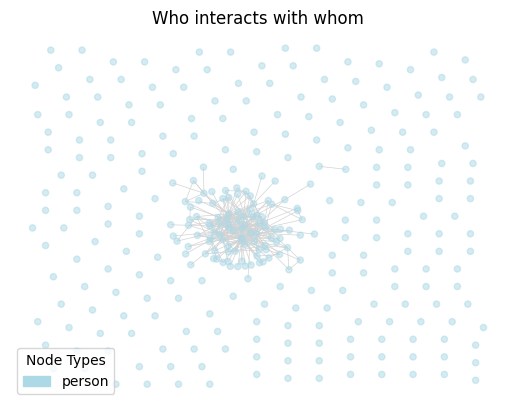

In [128]:
show_graph(G_mm, 
           ["person"], 
           pos = pos_mm,
           title = "Who interacts with whom")

Extract largest component

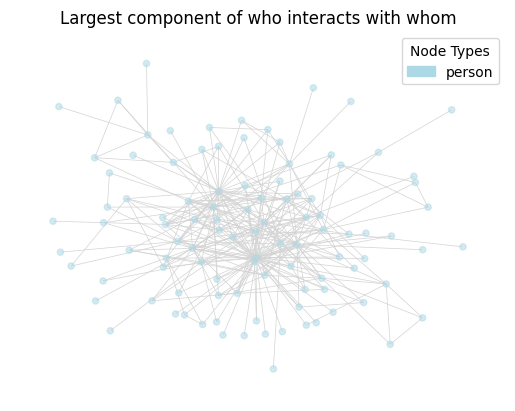

In [129]:
largest_cc = max(nx.connected_components(G_mm), key=len)
# Create a subgraph with only the largest component
largest_subgraph_mm = G_mm.subgraph(largest_cc).copy()
show_graph(largest_subgraph_mm,
           ["person"], 
           pos = pos_mm,
           title = "Largest component of who interacts with whom")

Look at some graph properties

In [130]:
print(f"density = {nx.density(largest_subgraph_mm)}")
print(f"assortativity = {nx.degree_assortativity_coefficient(largest_subgraph_mm)}")
print(f"transitivity = {nx.transitivity(largest_subgraph_mm)}")

density = 0.05998835177635411
assortativity = -0.2630990958885009
transitivity = 0.2323008849557522


Show communities

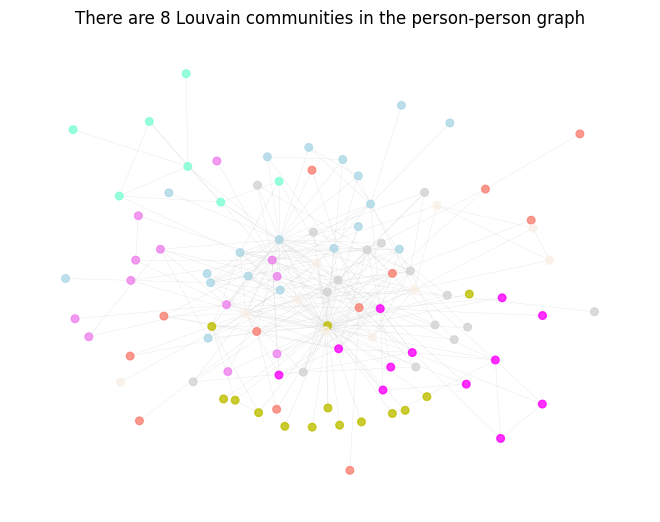

In [131]:
partition = nx.community.louvain_communities(largest_subgraph_mm)
color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'magenta', 'lightgray', 'linen']
node_color: list[str] = []
for node in largest_subgraph_mm.nodes():
    for i, group in enumerate(partition):
        if node in group:
            node_color.append(color_list[i%len(color_list)])
            continue
nx.draw(largest_subgraph_mm,
        pos_mm,
        node_color = node_color,
        alpha = 0.8,
        node_size = 30,
        width = 0.2,
        edge_color = 'lightgray')

_ = plt.title(f"There are {len(partition)} Louvain communities in the person-person graph")


The fact that there is a community structure suggests that we can expect local node neighborhood structure to contribute to finding a good node embedding. We'll want to augment the pure network structure with semantic information from the messages themselves.

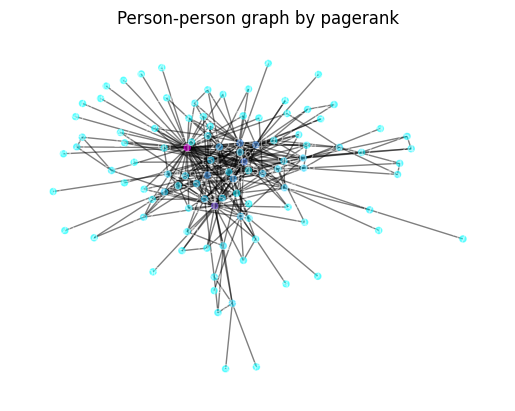

In [132]:
from drawing_utilities import show_graph_by_pagerank
show_graph_by_pagerank(largest_subgraph_mm,
                       pos=pos_mm,
                       title="Person-person graph by pagerank")

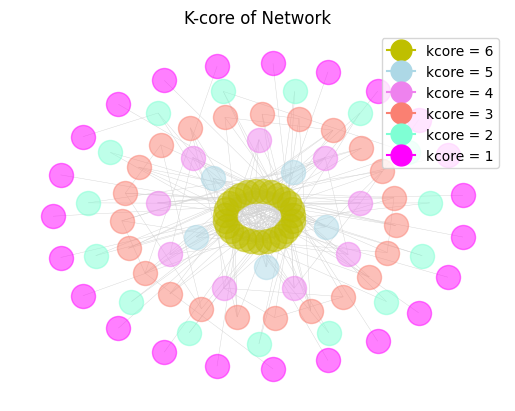

In [133]:
from drawing_utilities import show_kCores
show_kCores(largest_subgraph_mm)

In [134]:
most_influential: list[Hashable] = [(node, G_mm.degree(node)) for node in G_mm.nodes()]
most_influential = sorted(most_influential, key=lambda x: x[1], reverse=True)
i: int = 0
for node, degree in most_influential:
    print(f"Node {node} is a {G_mm.nodes[node]['node_value']} and has degree {degree}")
    i += 1
    if i>15:
        break

Node 1 is a TA and has degree 54
Node 113 is a Student and has degree 35
Node 41 is a TA and has degree 24
Node 54 is a Student and has degree 22
Node 87 is a Student and has degree 22
Node 75 is a TA and has degree 21
Node 116 is a Student and has degree 19
Node 222 is a Student and has degree 17
Node 259 is a Student and has degree 13
Node 282 is a Student and has degree 13
Node 37 is a Student and has degree 12
Node 150 is a Student and has degree 12
Node 151 is a Instructor and has degree 12
Node 115 is a Student and has degree 11
Node 158 is a Student and has degree 11
Node 208 is a Student and has degree 11


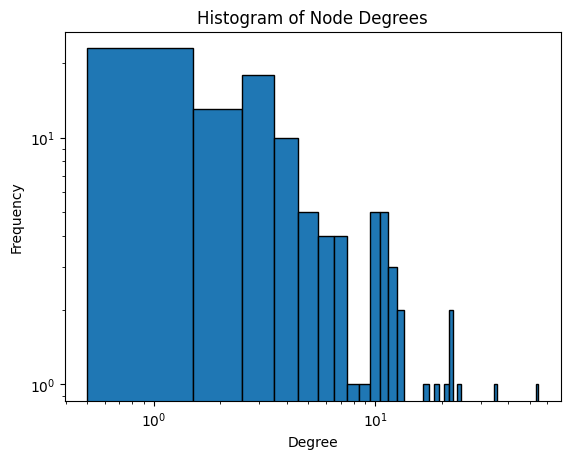

In [136]:
# Calculate degrees
degrees = [largest_subgraph_mm.degree(node) for node in largest_subgraph_mm.nodes()]

# Plot histogram of node degrees
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), edgecolor='black', align='left')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Node Degrees')
plt.xscale('log')
plt.yscale('log')

---
---